# Libraries
https://docs.pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [64]:
import torchvision
import torch
from tempfile import TemporaryDirectory
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from paths import IMAGES_DIR, LABEL_CSV
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import classification_report

cudnn.benchmark = True
plt.ion()   # interactive mode

# Load Data

In [25]:
test_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                         std = [0.229, 0.224, 0.225])
])

In [26]:
class CustomImageDataset(Dataset):
    def __init__(self, img_labels, img_dir, transform=None):
        self.img_labels = img_labels
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        row = self.img_labels.iloc[idx]
        filename = row["Filename"]
        img_path = self.img_dir / filename

        if not img_path.exists():
            print(f"[{idx}] Skipping missing image: {filename}")
            skipped_img_count +=1
            return None
        
        image = Image.open(img_path).convert('RGB')
        if image is None:
            print(f"[{idx}] Failed to load image: {filename}")
            failed_img_count +=1
            return None
        
        label = row["Label"]
        try:
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"[{idx}] Error processing {filename}: {e}")
            return None

        return image, label

In [27]:
df = pd.read_csv(LABEL_CSV)

In [28]:
classes = dict(sorted(zip(df['Label'], df['Species'])))
print(classes)

{0: 'Chinee apple', 1: 'Lantana', 2: 'Parkinsonia', 3: 'Parthenium', 4: 'Prickly acacia', 5: 'Rubber vine', 6: 'Siam weed', 7: 'Snake weed', 8: 'Negative'}


In [29]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['Label'], random_state=42)
test_df, validate_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Label'], random_state=42)

In [30]:
train_dataset = CustomImageDataset(train_df, IMAGES_DIR, train_transform)
val_dataset   = CustomImageDataset(validate_df, IMAGES_DIR, test_val_transform)
test_dataset  = CustomImageDataset(test_df, IMAGES_DIR, test_val_transform)

In [31]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader}

dataset_sizes = {
    "train": len(train_dataset),
    "val": len(val_dataset),
    "test": len(test_dataset)
}

In [32]:
for images, labels in val_loader:
    print("Images shape:", images.shape)   # [batch_size, 3, H, W]
    print("Labels shape:", labels.shape)   # [batch_size]
    print("Labels:", labels)               # Labels
    break

Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Labels: tensor([4, 4, 6, 2, 5, 1, 5, 8, 8, 1, 8, 8, 8, 2, 8, 8, 4, 8, 8, 8, 8, 6, 6, 3,
        7, 8, 7, 0, 8, 8, 4, 4])


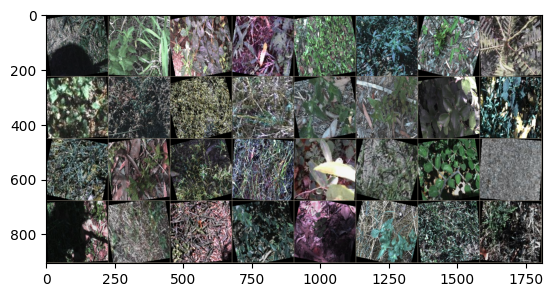

In [33]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out)

In [34]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Model

In [35]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == "train":
                    model.train()
                else:
                    model.eval()

                running_loss = 0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accuracies.append(epoch_acc.item())
                else:
                    val_losses.append(epoch_loss)
                    val_accuracies.append(epoch_acc.item())

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    
    return model, (train_accuracies, val_accuracies, train_losses, val_losses)



In [36]:
def plot_metrics(train_accuracies, val_accuracies, train_losses, val_losses, num_epochs):
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Acc')
    plt.plot(epochs, val_accuracies, label='Val Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Unfrozen


In [37]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(classes))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [38]:
model_ft, model_metrics = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.1007 Acc: 0.6408
val Loss: 0.5981 Acc: 0.7891

Epoch 1/24
----------
train Loss: 0.6936 Acc: 0.7593
val Loss: 0.4382 Acc: 0.8424

Epoch 2/24
----------
train Loss: 0.5821 Acc: 0.8040
val Loss: 0.3390 Acc: 0.8797

Epoch 3/24
----------
train Loss: 0.5182 Acc: 0.8229
val Loss: 0.3719 Acc: 0.8748

Epoch 4/24
----------
train Loss: 0.4706 Acc: 0.8386
val Loss: 0.3187 Acc: 0.8930

Epoch 5/24
----------
train Loss: 0.4448 Acc: 0.8484
val Loss: 0.3435 Acc: 0.8904

Epoch 6/24
----------
train Loss: 0.4155 Acc: 0.8590
val Loss: 0.2552 Acc: 0.9136

Epoch 7/24
----------
train Loss: 0.3772 Acc: 0.8761
val Loss: 0.2476 Acc: 0.9159

Epoch 8/24
----------
train Loss: 0.3631 Acc: 0.8783
val Loss: 0.2370 Acc: 0.9208

Epoch 9/24
----------
train Loss: 0.3510 Acc: 0.8819
val Loss: 0.2322 Acc: 0.9182

Epoch 10/24
----------
train Loss: 0.3423 Acc: 0.8820
val Loss: 0.2361 Acc: 0.9185

Epoch 11/24
----------
train Loss: 0.3353 Acc: 0.8874
val Loss: 0.2301 Acc: 0.9242

Ep

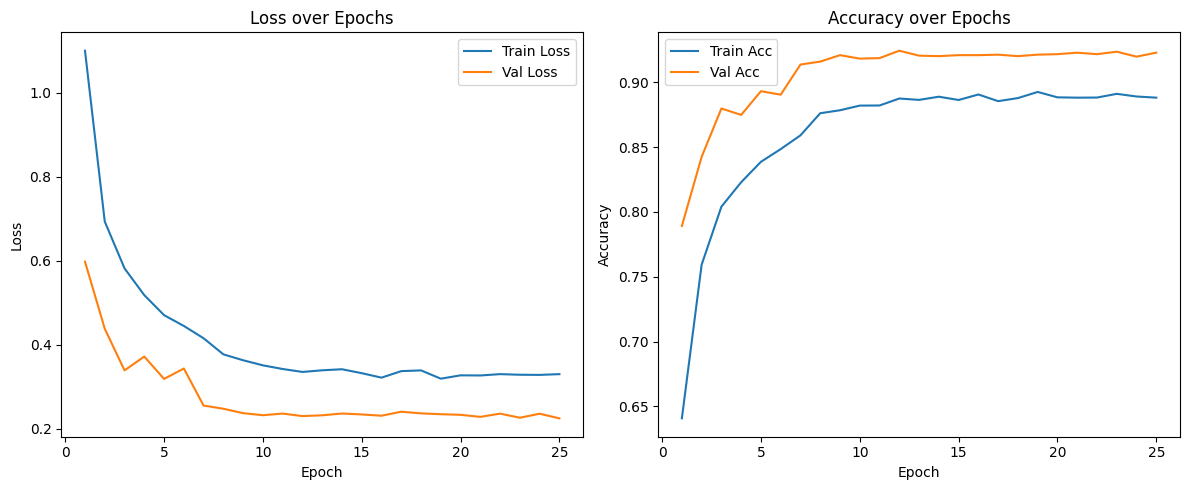

In [39]:
train_accuracies, val_accuracies, train_losses, val_losses = model_metrics
plot_metrics(train_accuracies, val_accuracies, train_losses, val_losses, num_epochs=25)

# Frozen Layers

In [50]:
for name, module in model_ft.named_children():
    print(name, "=>", module)

conv1 => Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
bn1 => BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
relu => ReLU(inplace=True)
maxpool => MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
layer1 => Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3

## All layers

In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(classes))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [41]:
model_ft, model_metrics = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3807 Acc: 0.5620
val Loss: 1.0373 Acc: 0.6479

Epoch 1/24
----------
train Loss: 1.0818 Acc: 0.6291
val Loss: 0.9070 Acc: 0.6920

Epoch 2/24
----------
train Loss: 1.0421 Acc: 0.6396
val Loss: 0.8805 Acc: 0.7004

Epoch 3/24
----------
train Loss: 1.0045 Acc: 0.6539
val Loss: 0.8782 Acc: 0.6905

Epoch 4/24
----------
train Loss: 0.9817 Acc: 0.6607
val Loss: 0.8780 Acc: 0.6939

Epoch 5/24
----------
train Loss: 0.9644 Acc: 0.6660
val Loss: 0.8079 Acc: 0.7107

Epoch 6/24
----------
train Loss: 0.9633 Acc: 0.6651
val Loss: 0.7812 Acc: 0.7240

Epoch 7/24
----------
train Loss: 0.9362 Acc: 0.6778
val Loss: 0.7804 Acc: 0.7236

Epoch 8/24
----------
train Loss: 0.9266 Acc: 0.6810
val Loss: 0.7693 Acc: 0.7255

Epoch 9/24
----------
train Loss: 0.9325 Acc: 0.6784
val Loss: 0.7810 Acc: 0.7278

Epoch 10/24
----------
train Loss: 0.9253 Acc: 0.6834
val Loss: 0.7876 Acc: 0.7202

Epoch 11/24
----------
train Loss: 0.9272 Acc: 0.6797
val Loss: 0.7870 Acc: 0.7195

Ep

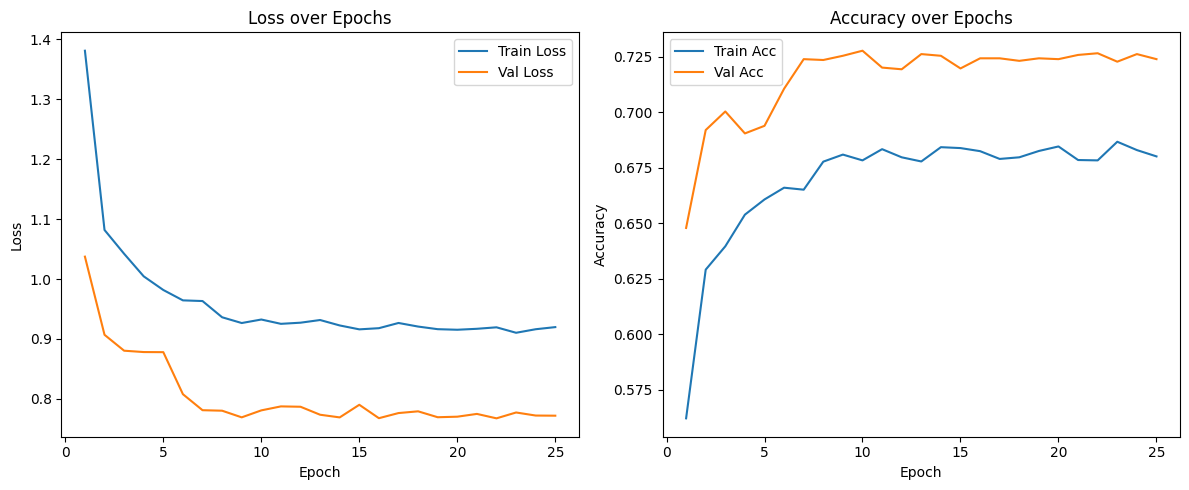

In [42]:
train_accuracies, val_accuracies, train_losses, val_losses = model_metrics
plot_metrics(train_accuracies, val_accuracies, train_losses, val_losses, num_epochs=25)

# Dropout


In [44]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for name, param in model_conv.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, len(classes))
)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD([
    {'params': model_conv.layer4.parameters(), 'lr': 1e-4},
    {'params': model_conv.fc.parameters(), 'lr': 1e-3}
], momentum=0.9, weight_decay=1e-4)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [45]:
model_ft, model_metrics = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.4968 Acc: 0.5329
val Loss: 0.9737 Acc: 0.6574

Epoch 1/24
----------
train Loss: 1.1970 Acc: 0.5946
val Loss: 0.9167 Acc: 0.6692

Epoch 2/24
----------
train Loss: 1.1153 Acc: 0.6160
val Loss: 0.8438 Acc: 0.6909

Epoch 3/24
----------
train Loss: 1.0692 Acc: 0.6287
val Loss: 0.7602 Acc: 0.7267

Epoch 4/24
----------
train Loss: 1.0371 Acc: 0.6396
val Loss: 0.7597 Acc: 0.7191

Epoch 5/24
----------
train Loss: 0.9960 Acc: 0.6538
val Loss: 0.7288 Acc: 0.7366

Epoch 6/24
----------
train Loss: 0.9890 Acc: 0.6518
val Loss: 0.6878 Acc: 0.7507

Epoch 7/24
----------
train Loss: 0.9456 Acc: 0.6691
val Loss: 0.6968 Acc: 0.7438

Epoch 8/24
----------
train Loss: 0.9314 Acc: 0.6748
val Loss: 0.6708 Acc: 0.7564

Epoch 9/24
----------
train Loss: 0.9351 Acc: 0.6724
val Loss: 0.6800 Acc: 0.7499

Epoch 10/24
----------
train Loss: 0.9242 Acc: 0.6786
val Loss: 0.6720 Acc: 0.7549

Epoch 11/24
----------
train Loss: 0.9216 Acc: 0.6811
val Loss: 0.6665 Acc: 0.7549

Ep

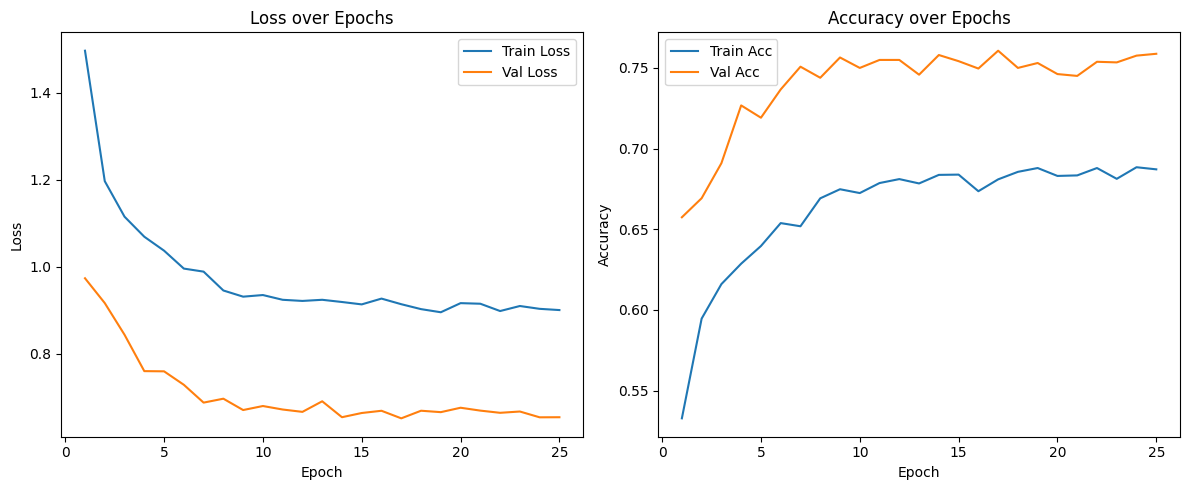

In [46]:
train_accuracies, val_accuracies, train_losses, val_losses = model_metrics
plot_metrics(train_accuracies, val_accuracies, train_losses, val_losses, num_epochs=25)

# Two layers

In [47]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for name, param in model_conv.named_parameters():
    if 'layer4' in name or 'fc' in name or 'layer3' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, len(classes))
)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD([
    {'params': model_conv.layer3.parameters(), 'lr': 1e-4},
    {'params': model_conv.layer4.parameters(), 'lr': 1e-4},
    {'params': model_conv.fc.parameters(), 'lr': 1e-3}
], momentum=0.9, weight_decay=1e-4)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [48]:
model_ft, model_metrics = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.4718 Acc: 0.5392
val Loss: 0.9987 Acc: 0.6464

Epoch 1/24
----------
train Loss: 1.1398 Acc: 0.6123
val Loss: 0.7993 Acc: 0.7153

Epoch 2/24
----------
train Loss: 1.0607 Acc: 0.6321
val Loss: 0.7239 Acc: 0.7347

Epoch 3/24
----------
train Loss: 1.0065 Acc: 0.6479
val Loss: 0.6872 Acc: 0.7495

Epoch 4/24
----------
train Loss: 0.9363 Acc: 0.6740
val Loss: 0.6510 Acc: 0.7659

Epoch 5/24
----------
train Loss: 0.9088 Acc: 0.6814
val Loss: 0.6212 Acc: 0.7735

Epoch 6/24
----------
train Loss: 0.8707 Acc: 0.6953
val Loss: 0.5889 Acc: 0.7884

Epoch 7/24
----------
train Loss: 0.8353 Acc: 0.7117
val Loss: 0.5851 Acc: 0.7868

Epoch 8/24
----------
train Loss: 0.8285 Acc: 0.7123
val Loss: 0.5978 Acc: 0.7887

Epoch 9/24
----------
train Loss: 0.8299 Acc: 0.7086
val Loss: 0.5696 Acc: 0.7971

Epoch 10/24
----------
train Loss: 0.8261 Acc: 0.7133
val Loss: 0.5609 Acc: 0.8013

Epoch 11/24
----------
train Loss: 0.8154 Acc: 0.7197
val Loss: 0.5707 Acc: 0.7971

Ep

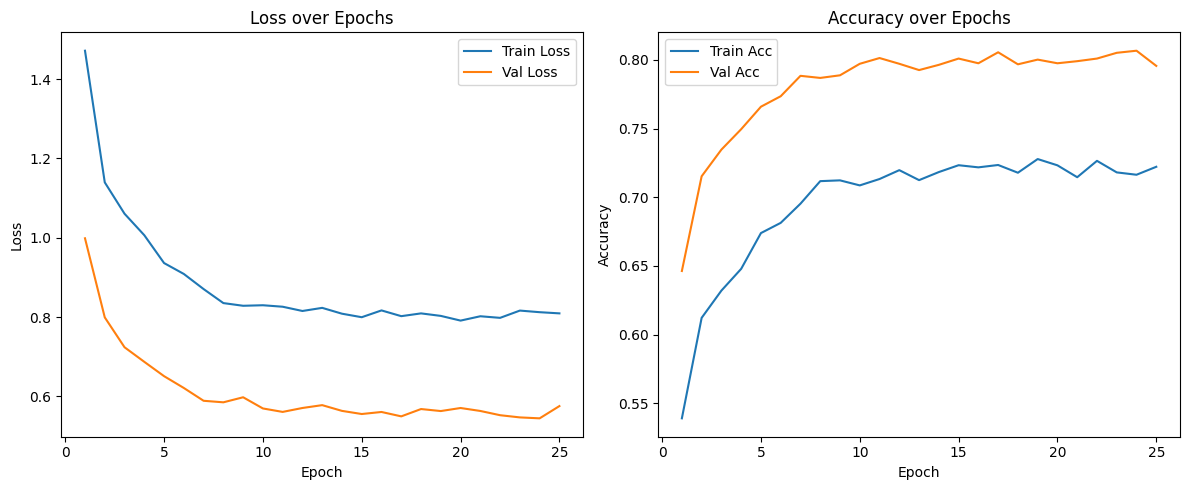

In [49]:
train_accuracies, val_accuracies, train_losses, val_losses = model_metrics
plot_metrics(train_accuracies, val_accuracies, train_losses, val_losses, num_epochs=25)

# Chosen Model

In [54]:
def define_model(trial):
    model = models.resnet18(weights='IMAGENET1K_V1')
    num_ftrs = model.fc.in_features
    dropout_rate = trial.suggest_float("dropout", 0.3, 0.7)
    
    model.fc = nn.Sequential(
        nn.Dropout(p=dropout_rate),
        nn.Linear(num_ftrs, len(classes))
    )
    return model.to(device)

def get_optimizer(trial, model):
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    if optimizer_name == "Adam":
        return optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        momentum = trial.suggest_float("momentum", 0.8, 0.99)
        return optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

def objective(trial):
    model = define_model(trial)
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer(trial, model)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Train the model
    model, (train_accs, val_accs, _, _) = train_model(
        model, criterion, optimizer, scheduler, num_epochs=10
    )

    return max(val_accs)

In [55]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)  # try 20 different hyperparameter combinations

print("Best trial:")
trial = study.best_trial

print(f"  Accuracy: {trial.value}")
print("  Best hyperparameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-05-29 18:11:03,232] A new study created in memory with name: no-name-44506f3b-fe74-4023-997d-f67e65f5b6b2


Epoch 0/9
----------
train Loss: 1.0845 Acc: 0.6629
val Loss: 0.5519 Acc: 0.8184

Epoch 1/9
----------
train Loss: 0.6601 Acc: 0.7781
val Loss: 0.4568 Acc: 0.8523

Epoch 2/9
----------
train Loss: 0.5595 Acc: 0.8126
val Loss: 0.3399 Acc: 0.8850

Epoch 3/9
----------
train Loss: 0.4975 Acc: 0.8325
val Loss: 0.3357 Acc: 0.8953

Epoch 4/9
----------
train Loss: 0.4765 Acc: 0.8375
val Loss: 0.3180 Acc: 0.8854

Epoch 5/9
----------
train Loss: 0.4347 Acc: 0.8542
val Loss: 0.2931 Acc: 0.9010

Epoch 6/9
----------
train Loss: 0.4037 Acc: 0.8648
val Loss: 0.3400 Acc: 0.8961

Epoch 7/9
----------
train Loss: 0.3458 Acc: 0.8852
val Loss: 0.1997 Acc: 0.9326

Epoch 8/9
----------
train Loss: 0.3068 Acc: 0.9004
val Loss: 0.1893 Acc: 0.9360

Epoch 9/9
----------
train Loss: 0.2959 Acc: 0.9023


[I 2025-05-29 19:00:51,019] Trial 0 finished with value: 0.9360487247811192 and parameters: {'dropout': 0.5480261721591532, 'optimizer': 'Adam', 'lr': 0.00010380219185885295, 'weight_decay': 0.0006886989770292808}. Best is trial 0 with value: 0.9360487247811192.


val Loss: 0.1991 Acc: 0.9349

Training complete in 49m 37s
Best val Acc: 0.936049
Epoch 0/9
----------
train Loss: 1.7239 Acc: 0.5145
val Loss: 1.2919 Acc: 0.5836

Epoch 1/9
----------
train Loss: 1.5801 Acc: 0.5502
val Loss: 1.5940 Acc: 0.5927

Epoch 2/9
----------
train Loss: 1.3199 Acc: 0.5902
val Loss: 1.1920 Acc: 0.6856

Epoch 3/9
----------
train Loss: 0.9417 Acc: 0.6760
val Loss: 0.9825 Acc: 0.7016

Epoch 4/9
----------
train Loss: 0.8036 Acc: 0.7306
val Loss: 0.5591 Acc: 0.8165

Epoch 5/9
----------
train Loss: 0.7527 Acc: 0.7503
val Loss: 0.6349 Acc: 0.7906

Epoch 6/9
----------
train Loss: 0.6823 Acc: 0.7736
val Loss: 0.5039 Acc: 0.8466

Epoch 7/9
----------
train Loss: 0.5460 Acc: 0.8176
val Loss: 0.3391 Acc: 0.8927

Epoch 8/9
----------
train Loss: 0.5065 Acc: 0.8277
val Loss: 0.3180 Acc: 0.8961

Epoch 9/9
----------
train Loss: 0.4941 Acc: 0.8351


[I 2025-05-29 19:34:32,954] Trial 1 finished with value: 0.9017891130567187 and parameters: {'dropout': 0.6521098523303533, 'optimizer': 'SGD', 'lr': 0.009683031258741181, 'weight_decay': 4.823240005094669e-06, 'momentum': 0.8311203566913534}. Best is trial 0 with value: 0.9360487247811192.


val Loss: 0.3068 Acc: 0.9018

Training complete in 33m 42s
Best val Acc: 0.901789
Epoch 0/9
----------
train Loss: 1.1224 Acc: 0.6295
val Loss: 0.7196 Acc: 0.7644

Epoch 1/9
----------
train Loss: 0.7564 Acc: 0.7459
val Loss: 0.6460 Acc: 0.7971

Epoch 2/9
----------
train Loss: 0.6426 Acc: 0.7856
val Loss: 0.9143 Acc: 0.8211

Epoch 3/9
----------
train Loss: 0.5867 Acc: 0.8052
val Loss: 0.3250 Acc: 0.8923

Epoch 4/9
----------
train Loss: 0.5433 Acc: 0.8205
val Loss: 0.4194 Acc: 0.8702

Epoch 5/9
----------
train Loss: 0.5040 Acc: 0.8344
val Loss: 0.3720 Acc: 0.8767

Epoch 6/9
----------
train Loss: 0.4943 Acc: 0.8367
val Loss: 0.4936 Acc: 0.8553

Epoch 7/9
----------
train Loss: 0.3855 Acc: 0.8719
val Loss: 0.2261 Acc: 0.9262

Epoch 8/9
----------
train Loss: 0.3483 Acc: 0.8813
val Loss: 0.2166 Acc: 0.9265

Epoch 9/9
----------
train Loss: 0.3362 Acc: 0.8841


[I 2025-05-29 20:06:06,674] Trial 2 finished with value: 0.9269128283212791 and parameters: {'dropout': 0.442633401959002, 'optimizer': 'SGD', 'lr': 0.0031029689843980763, 'weight_decay': 0.0005879313521359401, 'momentum': 0.9113473548088309}. Best is trial 0 with value: 0.9360487247811192.


val Loss: 0.2228 Acc: 0.9269

Training complete in 31m 33s
Best val Acc: 0.926913
Epoch 0/9
----------
train Loss: 1.1107 Acc: 0.6379
val Loss: 0.5855 Acc: 0.8085

Epoch 1/9
----------
train Loss: 0.7545 Acc: 0.7497
val Loss: 0.4516 Acc: 0.8375

Epoch 2/9
----------
train Loss: 0.6418 Acc: 0.7881
val Loss: 1.0965 Acc: 0.8070

Epoch 3/9
----------
train Loss: 0.5845 Acc: 0.8047
val Loss: 0.4609 Acc: 0.8470

Epoch 4/9
----------
train Loss: 0.5339 Acc: 0.8237
val Loss: 0.5533 Acc: 0.8458

Epoch 5/9
----------
train Loss: 0.5031 Acc: 0.8318
val Loss: 0.3502 Acc: 0.8820

Epoch 6/9
----------
train Loss: 0.5231 Acc: 0.8253
val Loss: 0.3617 Acc: 0.8888

Epoch 7/9
----------
train Loss: 0.3969 Acc: 0.8696
val Loss: 0.2600 Acc: 0.9151

Epoch 8/9
----------
train Loss: 0.3639 Acc: 0.8760
val Loss: 0.2567 Acc: 0.9204

Epoch 9/9
----------
train Loss: 0.3543 Acc: 0.8828


[I 2025-05-29 20:38:02,903] Trial 3 finished with value: 0.925770841263799 and parameters: {'dropout': 0.4639169736914404, 'optimizer': 'SGD', 'lr': 0.004279604111145198, 'weight_decay': 1.099574428690194e-06, 'momentum': 0.8832160058860863}. Best is trial 0 with value: 0.9360487247811192.


val Loss: 0.2311 Acc: 0.9258

Training complete in 31m 56s
Best val Acc: 0.925771
Epoch 0/9
----------
train Loss: 1.4557 Acc: 0.5133
val Loss: 1.6643 Acc: 0.5348

Epoch 1/9
----------
train Loss: 1.2572 Acc: 0.5599
val Loss: 1.0903 Acc: 0.6075

Epoch 2/9
----------
train Loss: 1.1501 Acc: 0.5916
val Loss: 1.6160 Acc: 0.5489

Epoch 3/9
----------
train Loss: 1.0539 Acc: 0.6219
val Loss: 0.8940 Acc: 0.6620

Epoch 4/9
----------
train Loss: 0.9964 Acc: 0.6460
val Loss: 0.7886 Acc: 0.7183

Epoch 5/9
----------
train Loss: 0.9253 Acc: 0.6740
val Loss: 0.9152 Acc: 0.7057

Epoch 6/9
----------
train Loss: 0.8941 Acc: 0.6893
val Loss: 0.7308 Acc: 0.7465

Epoch 7/9
----------
train Loss: 0.7204 Acc: 0.7479
val Loss: 0.4785 Acc: 0.8363

Epoch 8/9
----------
train Loss: 0.6481 Acc: 0.7699
val Loss: 0.4333 Acc: 0.8538

Epoch 9/9
----------
train Loss: 0.6369 Acc: 0.7817


[I 2025-05-29 21:10:00,870] Trial 4 finished with value: 0.853825656642558 and parameters: {'dropout': 0.565677117526346, 'optimizer': 'Adam', 'lr': 0.0014690348176046358, 'weight_decay': 7.783841466581731e-06}. Best is trial 0 with value: 0.9360487247811192.


val Loss: 0.4259 Acc: 0.8531

Training complete in 31m 58s
Best val Acc: 0.853826
Epoch 0/9
----------
train Loss: 2.8599 Acc: 0.3641
val Loss: 2.1379 Acc: 0.5200

Epoch 1/9
----------
train Loss: 2.3232 Acc: 0.4972
val Loss: 1.9054 Acc: 0.5204

Epoch 2/9
----------
train Loss: 2.1330 Acc: 0.4971
val Loss: 1.7402 Acc: 0.5204

Epoch 3/9
----------
train Loss: 1.9981 Acc: 0.4961
val Loss: 1.6332 Acc: 0.5219

Epoch 4/9
----------
train Loss: 1.9173 Acc: 0.4949
val Loss: 1.5541 Acc: 0.5230

Epoch 5/9
----------
train Loss: 1.8270 Acc: 0.4960
val Loss: 1.4788 Acc: 0.5246

Epoch 6/9
----------
train Loss: 1.7788 Acc: 0.4961
val Loss: 1.4257 Acc: 0.5276

Epoch 7/9
----------
train Loss: 1.7512 Acc: 0.4996
val Loss: 1.4238 Acc: 0.5280

Epoch 8/9
----------
train Loss: 1.7396 Acc: 0.5020
val Loss: 1.4177 Acc: 0.5299

Epoch 9/9
----------
train Loss: 1.7481 Acc: 0.4993


[I 2025-05-29 21:41:53,598] Trial 5 finished with value: 0.529881994670727 and parameters: {'dropout': 0.6630372494925467, 'optimizer': 'SGD', 'lr': 1.5357997390426928e-05, 'weight_decay': 4.52201474278018e-05, 'momentum': 0.8374355582716271}. Best is trial 0 with value: 0.9360487247811192.


val Loss: 1.4139 Acc: 0.5284

Training complete in 31m 52s
Best val Acc: 0.529882
Epoch 0/9
----------
train Loss: 1.2190 Acc: 0.6008
val Loss: 0.6194 Acc: 0.7769

Epoch 1/9
----------
train Loss: 0.7937 Acc: 0.7332
val Loss: 0.4788 Acc: 0.8382

Epoch 2/9
----------
train Loss: 0.6685 Acc: 0.7735
val Loss: 0.3940 Acc: 0.8675

Epoch 3/9
----------
train Loss: 0.5995 Acc: 0.8015
val Loss: 0.3843 Acc: 0.8725

Epoch 4/9
----------
train Loss: 0.5534 Acc: 0.8108
val Loss: 0.3507 Acc: 0.8888

Epoch 5/9
----------
train Loss: 0.5272 Acc: 0.8256
val Loss: 0.3660 Acc: 0.8805

Epoch 6/9
----------
train Loss: 0.4933 Acc: 0.8353
val Loss: 0.2740 Acc: 0.9090

Epoch 7/9
----------
train Loss: 0.4261 Acc: 0.8589
val Loss: 0.2432 Acc: 0.9216

Epoch 8/9
----------
train Loss: 0.4106 Acc: 0.8644
val Loss: 0.2353 Acc: 0.9242

Epoch 9/9
----------
train Loss: 0.3784 Acc: 0.8698


[I 2025-05-29 22:14:16,768] Trial 6 finished with value: 0.9261515036162924 and parameters: {'dropout': 0.6131646372777745, 'optimizer': 'SGD', 'lr': 0.001235399016670328, 'weight_decay': 5.644553779145945e-06, 'momentum': 0.918653264468027}. Best is trial 0 with value: 0.9360487247811192.


val Loss: 0.2334 Acc: 0.9262

Training complete in 32m 23s
Best val Acc: 0.926152
Epoch 0/9
----------
train Loss: 1.5332 Acc: 0.5325
val Loss: 0.8463 Acc: 0.7027

Epoch 1/9
----------
train Loss: 1.0321 Acc: 0.6439
val Loss: 0.6927 Acc: 0.7446

Epoch 2/9
----------
train Loss: 0.8798 Acc: 0.6894
val Loss: 0.5732 Acc: 0.7906

Epoch 3/9
----------
train Loss: 0.7751 Acc: 0.7356
val Loss: 0.4920 Acc: 0.8241

Epoch 4/9
----------
train Loss: 0.7186 Acc: 0.7577
val Loss: 0.4353 Acc: 0.8466

Epoch 5/9
----------
train Loss: 0.6690 Acc: 0.7732
val Loss: 0.3991 Acc: 0.8618

Epoch 6/9
----------
train Loss: 0.6269 Acc: 0.7908
val Loss: 0.3651 Acc: 0.8759

Epoch 7/9
----------
train Loss: 0.5868 Acc: 0.8021
val Loss: 0.3602 Acc: 0.8774

Epoch 8/9
----------
train Loss: 0.5799 Acc: 0.8033
val Loss: 0.3706 Acc: 0.8782

Epoch 9/9
----------
train Loss: 0.5777 Acc: 0.8062


[I 2025-05-29 22:46:32,286] Trial 7 finished with value: 0.8789493719071184 and parameters: {'dropout': 0.6943099463104392, 'optimizer': 'SGD', 'lr': 0.0007233979341166088, 'weight_decay': 0.00029927910509859325, 'momentum': 0.8259139683765325}. Best is trial 0 with value: 0.9360487247811192.


val Loss: 0.3595 Acc: 0.8789

Training complete in 32m 15s
Best val Acc: 0.878949
Epoch 0/9
----------
train Loss: 2.0838 Acc: 0.4504
val Loss: 1.0164 Acc: 0.7183

Epoch 1/9
----------
train Loss: 1.0868 Acc: 0.6822
val Loss: 0.7313 Acc: 0.7644

Epoch 2/9
----------
train Loss: 0.8562 Acc: 0.7298
val Loss: 0.5692 Acc: 0.8097

Epoch 3/9
----------
train Loss: 0.7328 Acc: 0.7635
val Loss: 0.4930 Acc: 0.8283

Epoch 4/9
----------
train Loss: 0.6668 Acc: 0.7782
val Loss: 0.4524 Acc: 0.8435

Epoch 5/9
----------
train Loss: 0.6094 Acc: 0.7986
val Loss: 0.4097 Acc: 0.8614

Epoch 6/9
----------
train Loss: 0.5762 Acc: 0.8069
val Loss: 0.3815 Acc: 0.8675

Epoch 7/9
----------
train Loss: 0.5423 Acc: 0.8179
val Loss: 0.3692 Acc: 0.8763

Epoch 8/9
----------
train Loss: 0.5472 Acc: 0.8197
val Loss: 0.3704 Acc: 0.8748

Epoch 9/9
----------
train Loss: 0.5383 Acc: 0.8215


[I 2025-05-30 01:30:10,229] Trial 8 finished with value: 0.876284735439665 and parameters: {'dropout': 0.3434865505557109, 'optimizer': 'Adam', 'lr': 1.2289034530444595e-05, 'weight_decay': 0.0006061217601225985}. Best is trial 0 with value: 0.9360487247811192.


val Loss: 0.3762 Acc: 0.8691

Training complete in 163m 38s
Best val Acc: 0.876285
Epoch 0/9
----------
train Loss: 1.7726 Acc: 0.5041
val Loss: 1.6574 Acc: 0.5177

Epoch 1/9
----------
train Loss: 1.5036 Acc: 0.5127
val Loss: 1.3743 Acc: 0.5367

Epoch 2/9
----------
train Loss: 1.4070 Acc: 0.5237
val Loss: 1.5847 Acc: 0.5287

Epoch 3/9
----------
train Loss: 1.3669 Acc: 0.5345
val Loss: 1.2713 Acc: 0.5501

Epoch 4/9
----------
train Loss: 1.3308 Acc: 0.5390
val Loss: 1.3294 Acc: 0.5272

Epoch 5/9
----------
train Loss: 1.3036 Acc: 0.5465
val Loss: 1.1558 Acc: 0.5912

Epoch 6/9
----------
train Loss: 1.2892 Acc: 0.5528
val Loss: 1.2632 Acc: 0.5504

Epoch 7/9
----------
train Loss: 1.2020 Acc: 0.5742
val Loss: 1.0751 Acc: 0.6041

Epoch 8/9
----------
train Loss: 1.1685 Acc: 0.5862
val Loss: 1.0046 Acc: 0.6270

Epoch 9/9
----------
train Loss: 1.1455 Acc: 0.5933


[I 2025-05-30 02:01:44,121] Trial 9 finished with value: 0.6269508945565284 and parameters: {'dropout': 0.5522405446602687, 'optimizer': 'Adam', 'lr': 0.0034638644602781243, 'weight_decay': 3.738430009982637e-05}. Best is trial 0 with value: 0.9360487247811192.


val Loss: 1.0385 Acc: 0.6171

Training complete in 31m 34s
Best val Acc: 0.626951
Epoch 0/9
----------
train Loss: 1.1655 Acc: 0.6520
val Loss: 0.4868 Acc: 0.8333

Epoch 1/9
----------
train Loss: 0.6496 Acc: 0.7836
val Loss: 0.3849 Acc: 0.8694

Epoch 2/9
----------
train Loss: 0.5489 Acc: 0.8166
val Loss: 0.3348 Acc: 0.8915

Epoch 3/9
----------
train Loss: 0.4919 Acc: 0.8303
val Loss: 0.4234 Acc: 0.8721

Epoch 4/9
----------
train Loss: 0.4574 Acc: 0.8478
val Loss: 0.2907 Acc: 0.9018

Epoch 5/9
----------
train Loss: 0.4252 Acc: 0.8573
val Loss: 0.2552 Acc: 0.9159

Epoch 6/9
----------
train Loss: 0.3967 Acc: 0.8637
val Loss: 0.2210 Acc: 0.9223

Epoch 7/9
----------
train Loss: 0.3318 Acc: 0.8904
val Loss: 0.1998 Acc: 0.9307

Epoch 8/9
----------
train Loss: 0.3109 Acc: 0.8956
val Loss: 0.1995 Acc: 0.9364

Epoch 9/9
----------
train Loss: 0.2896 Acc: 0.9032


[I 2025-05-30 02:33:23,899] Trial 10 finished with value: 0.9364293871336126 and parameters: {'dropout': 0.509019176084942, 'optimizer': 'Adam', 'lr': 9.725159977091148e-05, 'weight_decay': 0.00014932433484062777}. Best is trial 10 with value: 0.9364293871336126.


val Loss: 0.1936 Acc: 0.9364

Training complete in 31m 39s
Best val Acc: 0.936429
Epoch 0/9
----------
train Loss: 1.1434 Acc: 0.6493
val Loss: 0.4798 Acc: 0.8386

Epoch 1/9
----------
train Loss: 0.6724 Acc: 0.7734
val Loss: 0.3691 Acc: 0.8679

Epoch 2/9
----------
train Loss: 0.5637 Acc: 0.8096
val Loss: 0.3289 Acc: 0.8812

Epoch 3/9
----------
train Loss: 0.5063 Acc: 0.8278
val Loss: 0.3386 Acc: 0.8736

Epoch 4/9
----------
train Loss: 0.4578 Acc: 0.8446
val Loss: 0.2806 Acc: 0.9067

Epoch 5/9
----------
train Loss: 0.4239 Acc: 0.8552
val Loss: 0.2638 Acc: 0.9155

Epoch 6/9
----------
train Loss: 0.3888 Acc: 0.8721
val Loss: 0.2686 Acc: 0.9109

Epoch 7/9
----------
train Loss: 0.3368 Acc: 0.8886
val Loss: 0.2023 Acc: 0.9303

Epoch 8/9
----------
train Loss: 0.3160 Acc: 0.8949
val Loss: 0.1851 Acc: 0.9364

Epoch 9/9
----------
train Loss: 0.2993 Acc: 0.9008


[I 2025-05-30 03:03:52,551] Trial 11 finished with value: 0.9364293871336126 and parameters: {'dropout': 0.5127466981496743, 'optimizer': 'Adam', 'lr': 9.019900574071664e-05, 'weight_decay': 0.00014978543009442298}. Best is trial 10 with value: 0.9364293871336126.


val Loss: 0.1853 Acc: 0.9360

Training complete in 30m 28s
Best val Acc: 0.936429
Epoch 0/9
----------
train Loss: 1.0896 Acc: 0.6607
val Loss: 0.5421 Acc: 0.8059

Epoch 1/9
----------
train Loss: 0.6274 Acc: 0.7924
val Loss: 0.3849 Acc: 0.8698

Epoch 2/9
----------
train Loss: 0.5324 Acc: 0.8209
val Loss: 0.2955 Acc: 0.8957

Epoch 3/9
----------
train Loss: 0.4874 Acc: 0.8325
val Loss: 0.3077 Acc: 0.8923

Epoch 4/9
----------
train Loss: 0.4435 Acc: 0.8477
val Loss: 0.2708 Acc: 0.9090

Epoch 5/9
----------
train Loss: 0.4022 Acc: 0.8656
val Loss: 0.2469 Acc: 0.9166

Epoch 6/9
----------
train Loss: 0.3954 Acc: 0.8664
val Loss: 0.2443 Acc: 0.9121

Epoch 7/9
----------
train Loss: 0.3195 Acc: 0.8949
val Loss: 0.1831 Acc: 0.9349

Epoch 8/9
----------
train Loss: 0.2987 Acc: 0.8986
val Loss: 0.1726 Acc: 0.9421

Epoch 9/9
----------
train Loss: 0.2913 Acc: 0.9034


[I 2025-05-30 03:35:27,792] Trial 12 finished with value: 0.9421393224210126 and parameters: {'dropout': 0.3988190378286287, 'optimizer': 'Adam', 'lr': 8.940394699200718e-05, 'weight_decay': 0.00015233937821599504}. Best is trial 12 with value: 0.9421393224210126.


val Loss: 0.1726 Acc: 0.9387

Training complete in 31m 35s
Best val Acc: 0.942139
Epoch 0/9
----------
train Loss: 1.0142 Acc: 0.6802
val Loss: 0.4824 Acc: 0.8356

Epoch 1/9
----------
train Loss: 0.6259 Acc: 0.7855
val Loss: 0.3957 Acc: 0.8641

Epoch 2/9
----------
train Loss: 0.5415 Acc: 0.8163
val Loss: 0.3399 Acc: 0.8881

Epoch 3/9
----------
train Loss: 0.4856 Acc: 0.8351
val Loss: 0.3122 Acc: 0.8930

Epoch 4/9
----------
train Loss: 0.4511 Acc: 0.8469
val Loss: 0.3012 Acc: 0.9045

Epoch 5/9
----------
train Loss: 0.3995 Acc: 0.8593
val Loss: 0.2763 Acc: 0.8999

Epoch 6/9
----------
train Loss: 0.4000 Acc: 0.8632
val Loss: 0.2827 Acc: 0.9052

Epoch 7/9
----------
train Loss: 0.3207 Acc: 0.8918
val Loss: 0.1937 Acc: 0.9353

Epoch 8/9
----------
train Loss: 0.2989 Acc: 0.8965
val Loss: 0.1764 Acc: 0.9440

Epoch 9/9
----------
train Loss: 0.2705 Acc: 0.9098


[I 2025-05-30 04:06:48,075] Trial 13 finished with value: 0.9451846212409594 and parameters: {'dropout': 0.378165616334852, 'optimizer': 'Adam', 'lr': 0.0001290193785361685, 'weight_decay': 0.00010298048214934446}. Best is trial 13 with value: 0.9451846212409594.


val Loss: 0.1696 Acc: 0.9452

Training complete in 31m 20s
Best val Acc: 0.945185
Epoch 0/9
----------
train Loss: 0.9725 Acc: 0.6842
val Loss: 0.6080 Acc: 0.7918

Epoch 1/9
----------
train Loss: 0.6661 Acc: 0.7737
val Loss: 0.4005 Acc: 0.8618

Epoch 2/9
----------
train Loss: 0.5654 Acc: 0.8075
val Loss: 0.3340 Acc: 0.8793

Epoch 3/9
----------
train Loss: 0.5352 Acc: 0.8206
val Loss: 0.4787 Acc: 0.8397

Epoch 4/9
----------
train Loss: 0.4860 Acc: 0.8375
val Loss: 0.6710 Acc: 0.8009

Epoch 5/9
----------
train Loss: 0.4718 Acc: 0.8368
val Loss: 0.3582 Acc: 0.8755

Epoch 6/9
----------
train Loss: 0.4371 Acc: 0.8517
val Loss: 0.3186 Acc: 0.8957

Epoch 7/9
----------
train Loss: 0.3441 Acc: 0.8853
val Loss: 0.2067 Acc: 0.9322

Epoch 8/9
----------
train Loss: 0.3033 Acc: 0.8976
val Loss: 0.1946 Acc: 0.9364

Epoch 9/9
----------
train Loss: 0.2789 Acc: 0.9076


[I 2025-05-30 04:38:14,138] Trial 14 finished with value: 0.9390940236010659 and parameters: {'dropout': 0.34671257494819896, 'optimizer': 'Adam', 'lr': 0.0002447713853303297, 'weight_decay': 9.276187246364498e-05}. Best is trial 13 with value: 0.9451846212409594.


val Loss: 0.1902 Acc: 0.9391

Training complete in 31m 26s
Best val Acc: 0.939094
Epoch 0/9
----------
train Loss: 1.3702 Acc: 0.5975
val Loss: 0.5892 Acc: 0.7918

Epoch 1/9
----------
train Loss: 0.7118 Acc: 0.7645
val Loss: 0.4416 Acc: 0.8489

Epoch 2/9
----------
train Loss: 0.5957 Acc: 0.8004
val Loss: 0.3500 Acc: 0.8793

Epoch 3/9
----------
train Loss: 0.5116 Acc: 0.8238
val Loss: 0.3377 Acc: 0.8843

Epoch 4/9
----------
train Loss: 0.4789 Acc: 0.8393
val Loss: 0.3234 Acc: 0.8869

Epoch 5/9
----------
train Loss: 0.4553 Acc: 0.8450
val Loss: 0.2782 Acc: 0.9067

Epoch 6/9
----------
train Loss: 0.4104 Acc: 0.8601
val Loss: 0.3113 Acc: 0.8987

Epoch 7/9
----------
train Loss: 0.3800 Acc: 0.8728
val Loss: 0.2302 Acc: 0.9208

Epoch 8/9
----------
train Loss: 0.3699 Acc: 0.8770
val Loss: 0.2262 Acc: 0.9204

Epoch 9/9
----------
train Loss: 0.3547 Acc: 0.8816


[I 2025-05-30 05:09:44,284] Trial 15 finished with value: 0.9253901789113057 and parameters: {'dropout': 0.4101811480873373, 'optimizer': 'Adam', 'lr': 4.443835495945173e-05, 'weight_decay': 2.0673615112827288e-05}. Best is trial 13 with value: 0.9451846212409594.


val Loss: 0.2118 Acc: 0.9254

Training complete in 31m 30s
Best val Acc: 0.925390
Epoch 0/9
----------
train Loss: 0.9796 Acc: 0.6779
val Loss: 0.7256 Acc: 0.7800

Epoch 1/9
----------
train Loss: 0.6633 Acc: 0.7763
val Loss: 0.4223 Acc: 0.8466

Epoch 2/9
----------
train Loss: 0.5792 Acc: 0.8006
val Loss: 0.6138 Acc: 0.8097

Epoch 3/9
----------
train Loss: 0.5386 Acc: 0.8152
val Loss: 0.4534 Acc: 0.8588

Epoch 4/9
----------
train Loss: 0.5054 Acc: 0.8238
val Loss: 0.4639 Acc: 0.8542

Epoch 5/9
----------
train Loss: 0.4753 Acc: 0.8393
val Loss: 0.4846 Acc: 0.8428

Epoch 6/9
----------
train Loss: 0.4527 Acc: 0.8462
val Loss: 0.3462 Acc: 0.8858

Epoch 7/9
----------
train Loss: 0.3519 Acc: 0.8814
val Loss: 0.2035 Acc: 0.9281

Epoch 8/9
----------
train Loss: 0.2972 Acc: 0.9001
val Loss: 0.1871 Acc: 0.9372

Epoch 9/9
----------
train Loss: 0.2935 Acc: 0.9031


[I 2025-05-30 05:41:11,895] Trial 16 finished with value: 0.9379520365435858 and parameters: {'dropout': 0.39307582420298953, 'optimizer': 'Adam', 'lr': 0.00026453064507673537, 'weight_decay': 6.856813984451109e-05}. Best is trial 13 with value: 0.9451846212409594.


val Loss: 0.1864 Acc: 0.9380

Training complete in 31m 27s
Best val Acc: 0.937952
Epoch 0/9
----------
train Loss: 1.2221 Acc: 0.6369
val Loss: 0.5027 Acc: 0.8325

Epoch 1/9
----------
train Loss: 0.6748 Acc: 0.7724
val Loss: 0.4141 Acc: 0.8519

Epoch 2/9
----------
train Loss: 0.5550 Acc: 0.8124
val Loss: 0.3075 Acc: 0.8896

Epoch 3/9
----------
train Loss: 0.4912 Acc: 0.8317
val Loss: 0.3108 Acc: 0.8869

Epoch 4/9
----------
train Loss: 0.4670 Acc: 0.8426
val Loss: 0.2677 Acc: 0.9014

Epoch 5/9
----------
train Loss: 0.4245 Acc: 0.8575
val Loss: 0.2602 Acc: 0.9067

Epoch 6/9
----------
train Loss: 0.3914 Acc: 0.8679
val Loss: 0.2558 Acc: 0.9083

Epoch 7/9
----------
train Loss: 0.3591 Acc: 0.8743
val Loss: 0.2073 Acc: 0.9250

Epoch 8/9
----------
train Loss: 0.3303 Acc: 0.8894
val Loss: 0.2111 Acc: 0.9235

Epoch 9/9
----------
train Loss: 0.3241 Acc: 0.8913


[I 2025-05-30 06:12:31,247] Trial 17 finished with value: 0.9318614389036924 and parameters: {'dropout': 0.30129784082559696, 'optimizer': 'Adam', 'lr': 4.5433516954595434e-05, 'weight_decay': 0.0002567507142970773}. Best is trial 13 with value: 0.9451846212409594.


val Loss: 0.2021 Acc: 0.9319

Training complete in 31m 19s
Best val Acc: 0.931861
Epoch 0/9
----------
train Loss: 1.0590 Acc: 0.6473
val Loss: 1.0338 Acc: 0.6475

Epoch 1/9
----------
train Loss: 0.7789 Acc: 0.7357
val Loss: 0.5602 Acc: 0.8161

Epoch 2/9
----------
train Loss: 0.7052 Acc: 0.7583
val Loss: 0.8127 Acc: 0.7609

Epoch 3/9
----------
train Loss: 0.6718 Acc: 0.7673
val Loss: 0.7192 Acc: 0.7864

Epoch 4/9
----------
train Loss: 0.6119 Acc: 0.7901
val Loss: 0.4973 Acc: 0.8390

Epoch 5/9
----------
train Loss: 0.5636 Acc: 0.8065
val Loss: 0.4136 Acc: 0.8633

Epoch 6/9
----------
train Loss: 0.5550 Acc: 0.8136
val Loss: 0.4710 Acc: 0.8493

Epoch 7/9
----------
train Loss: 0.4224 Acc: 0.8535
val Loss: 0.2416 Acc: 0.9174

Epoch 8/9
----------
train Loss: 0.3630 Acc: 0.8739
val Loss: 0.2293 Acc: 0.9189

Epoch 9/9
----------
train Loss: 0.3562 Acc: 0.8793


[I 2025-05-30 10:59:03,234] Trial 18 finished with value: 0.9253901789113057 and parameters: {'dropout': 0.4016839800896287, 'optimizer': 'Adam', 'lr': 0.0005424650370952203, 'weight_decay': 2.155093684394686e-05}. Best is trial 13 with value: 0.9451846212409594.


val Loss: 0.2240 Acc: 0.9254

Training complete in 286m 32s
Best val Acc: 0.925390
Epoch 0/9
----------
train Loss: 1.6383 Acc: 0.5509
val Loss: 0.6632 Acc: 0.7868

Epoch 1/9
----------
train Loss: 0.7903 Acc: 0.7446
val Loss: 0.5040 Acc: 0.8348

Epoch 2/9
----------
train Loss: 0.6506 Acc: 0.7823
val Loss: 0.4064 Acc: 0.8550

Epoch 3/9
----------
train Loss: 0.5606 Acc: 0.8105
val Loss: 0.3575 Acc: 0.8713

Epoch 4/9
----------
train Loss: 0.5221 Acc: 0.8262
val Loss: 0.3331 Acc: 0.8873

Epoch 5/9
----------
train Loss: 0.4759 Acc: 0.8376
val Loss: 0.2999 Acc: 0.8946

Epoch 6/9
----------
train Loss: 0.4395 Acc: 0.8515
val Loss: 0.2653 Acc: 0.9079

Epoch 7/9
----------
train Loss: 0.4161 Acc: 0.8629
val Loss: 0.2641 Acc: 0.9052

Epoch 8/9
----------
train Loss: 0.4024 Acc: 0.8650
val Loss: 0.2562 Acc: 0.9079

Epoch 9/9
----------
train Loss: 0.4009 Acc: 0.8622


[I 2025-05-30 11:30:35,764] Trial 19 finished with value: 0.9086410354015988 and parameters: {'dropout': 0.35395667732724834, 'optimizer': 'Adam', 'lr': 2.904600268959512e-05, 'weight_decay': 0.00026907172829229156}. Best is trial 13 with value: 0.9451846212409594.


val Loss: 0.2532 Acc: 0.9086

Training complete in 31m 32s
Best val Acc: 0.908641
Best trial:
  Accuracy: 0.9451846212409594
  Best hyperparameters:
    dropout: 0.378165616334852
    optimizer: Adam
    lr: 0.0001290193785361685
    weight_decay: 0.00010298048214934446


In [56]:
best_params = study.best_params
# build and train your model again using best_params
print(best_params)

{'dropout': 0.378165616334852, 'optimizer': 'Adam', 'lr': 0.0001290193785361685, 'weight_decay': 0.00010298048214934446}


# Model

In [57]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
model_conv.fc = nn.Sequential(
    nn.Dropout(p=best_params["dropout"]),
    nn.Linear(num_ftrs, len(classes))
)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [58]:
model_ft, model_metrics = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3123 Acc: 0.6687
val Loss: 0.6024 Acc: 0.8135

Epoch 1/24
----------
train Loss: 0.6356 Acc: 0.7815
val Loss: 0.3921 Acc: 0.8603

Epoch 2/24
----------
train Loss: 0.5419 Acc: 0.8135
val Loss: 0.3464 Acc: 0.8881

Epoch 3/24
----------
train Loss: 0.4865 Acc: 0.8344
val Loss: 0.3432 Acc: 0.8850

Epoch 4/24
----------
train Loss: 0.4457 Acc: 0.8477
val Loss: 0.3275 Acc: 0.8927

Epoch 5/24
----------
train Loss: 0.4130 Acc: 0.8593
val Loss: 0.3728 Acc: 0.8835

Epoch 6/24
----------
train Loss: 0.4123 Acc: 0.8593
val Loss: 0.3766 Acc: 0.8778

Epoch 7/24
----------
train Loss: 0.3095 Acc: 0.8921
val Loss: 0.2098 Acc: 0.9284

Epoch 8/24
----------
train Loss: 0.2831 Acc: 0.9023
val Loss: 0.1951 Acc: 0.9376

Epoch 9/24
----------
train Loss: 0.2682 Acc: 0.9094
val Loss: 0.1963 Acc: 0.9357

Epoch 10/24
----------
train Loss: 0.2549 Acc: 0.9153
val Loss: 0.2021 Acc: 0.9322

Epoch 11/24
----------
train Loss: 0.2528 Acc: 0.9155
val Loss: 0.1861 Acc: 0.9364

Ep

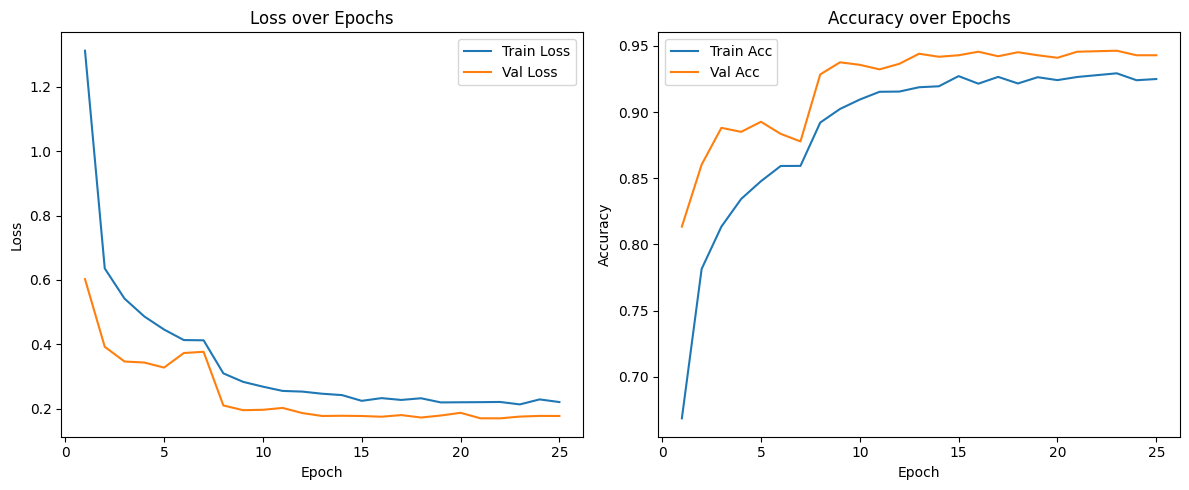

In [59]:
train_accuracies, val_accuracies, train_losses, val_losses = model_metrics
plot_metrics(train_accuracies, val_accuracies, train_losses, val_losses, num_epochs=25)

# Test

In [61]:
final_model = model_ft
final_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = final_model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [66]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       168
           1       0.93      0.94      0.94       159
           2       0.94      0.98      0.96       154
           3       0.95      0.91      0.93       154
           4       0.96      0.89      0.93       159
           5       0.97      0.94      0.96       152
           6       0.94      0.93      0.93       161
           7       0.94      0.88      0.91       153
           8       0.95      0.97      0.96      1366

    accuracy                           0.94      2626
   macro avg       0.94      0.92      0.93      2626
weighted avg       0.94      0.94      0.94      2626

